<a href="https://colab.research.google.com/github/tottenjordan/stock-pred/blob/master/EDA/stockRet_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=7cd7f6aed8a40fc43cd2d72071a6b927bf1b53cdf0c8a55ecc11450b578ea256
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [ ]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
pd.set_option("display.max_columns", None, 'display.max_rows', None)
from collections import deque
import datetime
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# %matplotlib inline

# NLTK VADER for sentiment analysis
import nltk
import warnings
#warnings.filterwarnings('ignore')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# finance data
import yfinance as yf
# from yahoo_fin import stock_info as si

finwiz_url = 'https://finviz.com/quote.ashx?t='

%load_ext tensorboard

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
news_tables = {}
tickers = ['LVGO', 'FSLY', 'CGNX', 'NVDA']
# tickers = ['ZM','PYPL','AMZN','AAPL','GOOG','DIS','JPM','UBER','BABA','TSLA','LVGO', 'FSLY', 'CGNX', 'NVDA']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [ ]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.tail(5)

,ticker,date,time,headline,neg,neu,pos,compound
395,NVDA,2020-06-16,12:46PM,AMD's New Radeon Pro GPUs to Boost MacBook Pro...,0.0,0.769,0.231,0.4019
396,NVDA,2020-06-16,10:09AM,"Nvidia, Intel stocks get downgraded at Morgan ...",0.0,1.000,0.000,0.0000
397,NVDA,2020-06-16,09:25AM,"Nvidia and Intel Shares Downgraded, Largely on...",0.0,0.761,0.239,0.2960
398,NVDA,2020-06-16,07:43AM,Major Indexes Post Best Intraday Rebound in 3 ...,0.0,0.656,0.344,0.6369
399,NVDA,2020-06-15,06:54PM,US Indexes End With Gains Monday,0.0,0.676,0.324,0.3400


## gather financial data

In [ ]:
# load yahoo data
def load_fin_data(ticker, start_date, end_date, lookup_step=1, progress=False, feature_columns=['Adj Close', 'Volume', 'Open', 'High', 'Low']):
    """
    Loads data from Yahoo Finance source, creates additional feature columns, and creates multiple target columns.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        start_date / end_date (date): first and last dates of the series to download
        progress (bool): shows progress bar for downloading from yahoo, default is False
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = yf.download(ticker, start=start_date, end=end_date, progress=progress)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    # add features e.g., returns and log returns
    df = df.rename(columns={'Adj Close':'Adj_Close'})
    df['returns'] = df['Adj_Close'].pct_change()
    df['log_returns'] = np.log(df['Adj_Close']).diff()
    df['volatility'] = df['log_returns'].rolling(window=200).std() * np.sqrt(200)
    df['close_3day_mean'] = df['Adj_Close'].rolling(window=3).mean()
    df['close_5day_mean'] = df['Adj_Close'].rolling(window=5).mean()
    df['close_20day_mean'] = df['Adj_Close'].rolling(window=20).mean()
    df['volume_3day_mean'] = df['Volume'].rolling(window=3).mean()
    df['volume_5day_mean'] = df['Volume'].rolling(window=5).mean()
    df['volume_20day_mean'] = df['Volume'].rolling(window=20).mean()
    df['volume_avg'] = df['Volume'] / df['Volume'].rolling(window=200).mean()
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['returns_signal'] = np.where(df['log_returns'] > 0, 1, 0)
    

    # add target columns (labels) by shifting by `lookup_step`
    df['future_close'] = df['Adj_Close'].shift(-lookup_step)
    df['future_returns'] = df['returns'].shift(-lookup_step)
    df['future_logReturns'] = df['log_returns'].shift(-lookup_step)
    df['future_returns_signal'] = df['returns_signal'].shift(-lookup_step)
    
    # drop NaNs
    df.dropna(inplace=True)

    # convert to integer
    df['future_returns_signal'] = df['future_returns_signal'].astype(int)

    return df

### CGNX - with sentiment data

In [ ]:
# get timeline from available headline data
headline_df = parsed_and_scored_news.groupby(['ticker','date']).mean()
headline_df = headline_df.unstack()
headline_df = headline_df.xs('compound', axis="columns").transpose()

# compounded sentiment 
cgnx_compound = headline_df['CGNX'].dropna()
print("Compound Series Shape: ", cgnx_compound.shape)

# start and end dates
start_stock = cgnx_compound.first_valid_index() - datetime.timedelta(days=300)
start_cgnx = cgnx_compound.first_valid_index() - datetime.timedelta(days=7)
end_cgnx = cgnx_compound.last_valid_index() # + datetime.timedelta(days=7)
print("Start Date (Stock): ", start_stock)
print("Start Date: ", start_cgnx)
print("End Date:   ", end_cgnx)

# load data
cgnx_df = load_fin_data('CGNX', start_date=start_stock, end_date=end_cgnx, lookup_step=1, progress=False, feature_columns=['Adj Close', 'Volume', 'Open', 'High', 'Low'])

# truncate for consistency (later sentiment models)
cgnx_df = cgnx_df.truncate(before=start_cgnx)

cgnx_df.columns = ['CGNX_' + str(col) for col in cgnx_df.columns]

print("Shape:", cgnx_df.shape)
cgnx_df.head()

Compound Series Shape:  (76,)
Start Date (Stock):  2018-04-30
Start Date:  2019-02-17
End Date:    2020-07-06
Shape: (346, 22)


,CGNX_Open,CGNX_High,CGNX_Low,CGNX_Close,CGNX_Adj_Close,CGNX_Volume,CGNX_returns,CGNX_log_returns,CGNX_volatility,CGNX_close_3day_mean,CGNX_close_5day_mean,CGNX_close_20day_mean,CGNX_volume_3day_mean,CGNX_volume_5day_mean,CGNX_volume_20day_mean,CGNX_volume_avg,CGNX_day_of_week,CGNX_returns_signal,CGNX_future_close,CGNX_future_returns,CGNX_future_logReturns,CGNX_future_returns_signal
Date,,,,,,,,,,,,,,,,,,,,,,
2019-02-19,50.380001,51.610001,50.009998,51.490002,51.159763,1425800,0.014981,0.014870,0.394928,50.040319,49.639572,45.922567,2.619433e+06,2348620.0,1431115.0,1.055838,1,1,50.941174,-0.004273,-0.004282,0
2019-02-20,51.169998,52.160000,50.750000,51.270000,50.941174,1510000,-0.004273,-0.004282,0.394293,50.835190,50.023097,46.407934,2.144400e+06,2225840.0,1447135.0,1.123241,2,0,50.871620,-0.001365,-0.001366,0
2019-02-21,51.180000,51.250000,50.439999,51.200001,50.871620,858600,-0.001365,-0.001366,0.393690,50.990852,50.386750,46.921121,1.264800e+06,2045380.0,1437900.0,0.641936,3,0,51.497581,0.012305,0.012230,1
2019-02-22,51.410000,51.910000,51.380001,51.830002,51.497581,932600,0.012305,0.012230,0.393441,51.103458,50.974954,47.398540,1.100400e+06,1644880.0,1407720.0,0.702673,4,1,53.017769,0.029520,0.029092,1
2019-02-25,52.189999,53.480000,52.070000,53.360001,53.017769,1696500,0.029520,0.029092,0.394227,51.795657,51.497581,47.874964,1.162567e+06,1284700.0,1445790.0,1.280887,0,1,53.504623,0.009183,0.009141,1


## Indices

In [ ]:
indices = ['^GSPC', '^DJI', '^VIX', '^IXIC']

# get timeline from available headline data
headline_df = parsed_and_scored_news.groupby(['ticker','date']).mean()
headline_df = headline_df.unstack()
headline_df = headline_df.xs('compound', axis="columns").transpose()

start_date_i = headline_df.first_valid_index() - datetime.timedelta(days=300)
end_date_i = headline_df.last_valid_index()

# gspc_df = yf.download('^GSPC', start=start_date_i, end=end_date_i, progress=False)
gspc_df = load_fin_data('^GSPC', start_date=start_date_i, end_date=end_date_i, lookup_step=1, progress=False, feature_columns=['Adj Close', 'Volume', 'Open', 'High', 'Low'])
gspc_df.columns = ['GSPC_' + str(col) for col in gspc_df.columns]

# dji_df = yf.download('^DJI', start=start_date_i, end=end_date_i, progress=False)
dji_df = load_fin_data('^DJI', start_date=start_date_i, end_date=end_date_i, lookup_step=1, progress=False, feature_columns=['Adj Close', 'Volume', 'Open', 'High', 'Low'])
dji_df.columns = ['DJI_' + str(col) for col in dji_df.columns]

# ixic_df = yf.download('^IXIC', start=start_date_i, end=end_date_i, progress=False)
ixic_df = load_fin_data('^IXIC', start_date=start_date_i, end_date=end_date_i, lookup_step=1, progress=False, feature_columns=['Adj Close', 'Volume', 'Open', 'High', 'Low'])
ixic_df.columns = ['IXIC_' + str(col) for col in ixic_df.columns]

# VIX trading Volume is 0, can't use data load function
# vix_df = yf.download('^VIX', start=start_date_i, end=end_date_i, progress=False)
# vix_df = yf.download('^VIX', start=start_date_i, end=end_date_i, progress=False)
# vix_df.columns = ['VIX_' + str(col) for col in vix_df.columns]

# vix_df = yf.download('^VIX', start=start_date_i, end=end_date_i, progress=False)
vix_df = yf.download('^VIX', start=start_date_i, end=end_date_i, progress=False)

vix_df = vix_df.rename(columns={'Adj Close':'Adj_Close'})
vix_df['returns'] = vix_df['Adj_Close'].pct_change()
vix_df['log_returns'] = np.log(vix_df['Adj_Close']).diff()
vix_df['volatility'] = vix_df['log_returns'].rolling(window=200).std() * np.sqrt(200)
vix_df['close_3day_mean'] = vix_df['Adj_Close'].rolling(window=3).mean()
vix_df['close_5day_mean'] = vix_df['Adj_Close'].rolling(window=5).mean()
vix_df['close_20day_mean'] = vix_df['Adj_Close'].rolling(window=20).mean()
vix_df['day_of_week'] = vix_df.index.dayofweek
vix_df['returns_signal'] = np.where(vix_df['log_returns'] > 0, 1, 0)

vix_df = vix_df.drop(columns=['Volume'])
vix_df.columns = ['VIX_' + str(col) for col in vix_df.columns]
# drop NaNs
vix_df.dropna(inplace=True)


print("GSPC Shape: ", gspc_df.shape)
print("DJI Shape: ", dji_df.shape)
print("VIX Shape: ", vix_df.shape)
print("IXIC Shape: ", ixic_df.shape)

gspc_df.head()

GSPC Shape:  (348, 22)
DJI Shape:  (348, 22)
VIX Shape:  (349, 13)
IXIC Shape:  (348, 22)


,GSPC_Open,GSPC_High,GSPC_Low,GSPC_Close,GSPC_Adj_Close,GSPC_Volume,GSPC_returns,GSPC_log_returns,GSPC_volatility,GSPC_close_3day_mean,GSPC_close_5day_mean,GSPC_close_20day_mean,GSPC_volume_3day_mean,GSPC_volume_5day_mean,GSPC_volume_20day_mean,GSPC_volume_avg,GSPC_day_of_week,GSPC_returns_signal,GSPC_future_close,GSPC_future_returns,GSPC_future_logReturns,GSPC_future_returns_signal
Date,,,,,,,,,,,,,,,,,,,,,,
2019-02-14,2743.500000,2757.899902,2731.229980,2745.729980,2745.729980,3836700000,-0.002652,-0.002655,0.143381,2747.829997,2732.233984,2691.114514,3.778413e+09,3.663908e+09,3.736185e+09,1.063928,3,0,2775.600098,0.010879,0.010820,1
2019-02-15,2760.239990,2775.659912,2760.239990,2775.600098,2775.600098,3641370000,0.010879,0.010820,0.143757,2758.120036,2745.778027,2698.096521,3.716280e+09,3.667716e+09,3.729640e+09,1.009648,4,1,2779.760010,0.001499,0.001498,1
2019-02-19,2769.280029,2787.330078,2767.290039,2779.760010,2779.760010,3533710000,0.001499,0.001498,0.143567,2767.030029,2759.770020,2703.549023,3.670593e+09,3.702064e+09,3.706989e+09,0.980446,1,1,2784.699951,0.001777,0.001776,1
2019-02-20,2779.050049,2789.879883,2774.060059,2784.699951,2784.699951,3835450000,0.001777,0.001776,0.143552,2780.020020,2767.764014,2711.139026,3.670177e+09,3.703600e+09,3.703360e+09,1.064189,2,1,2774.879883,-0.003526,-0.003533,0
2019-02-21,2780.239990,2781.580078,2764.550049,2774.879883,2774.879883,3559710000,-0.003526,-0.003533,0.143056,2779.779948,2772.133984,2717.948022,3.642957e+09,3.681388e+09,3.714565e+09,0.987363,3,0,2792.669922,0.006411,0.006391,1


In [ ]:
market_index_df = gspc_df.join(dji_df).join(vix_df).join(ixic_df).join(cgnx_df).join(cgnx_compound)

market_index_df = market_index_df.rename(columns={'CGNX':'CGNX_Sentiment'})
market_index_df['CGNX_Sentiment'] = market_index_df['CGNX_Sentiment'].fillna(method='ffill')
market_index_df['CGNX_Sentiment'] = market_index_df['CGNX_Sentiment'].fillna(0)
market_index_df.dropna(inplace=True)
print(market_index_df.shape)
market_index_df.head()

(346, 102)


,GSPC_Open,GSPC_High,GSPC_Low,GSPC_Close,GSPC_Adj_Close,GSPC_Volume,GSPC_returns,GSPC_log_returns,GSPC_volatility,GSPC_close_3day_mean,GSPC_close_5day_mean,GSPC_close_20day_mean,GSPC_volume_3day_mean,GSPC_volume_5day_mean,GSPC_volume_20day_mean,GSPC_volume_avg,GSPC_day_of_week,GSPC_returns_signal,GSPC_future_close,GSPC_future_returns,GSPC_future_logReturns,GSPC_future_returns_signal,DJI_Open,DJI_High,DJI_Low,DJI_Close,DJI_Adj_Close,DJI_Volume,DJI_returns,DJI_log_returns,DJI_volatility,DJI_close_3day_mean,DJI_close_5day_mean,DJI_close_20day_mean,DJI_volume_3day_mean,DJI_volume_5day_mean,DJI_volume_20day_mean,DJI_volume_avg,DJI_day_of_week,DJI_returns_signal,DJI_future_close,DJI_future_returns,DJI_future_logReturns,DJI_future_returns_signal,VIX_Open,VIX_High,VIX_Low,VIX_Close,VIX_Adj_Close,VIX_returns,VIX_log_returns,VIX_volatility,VIX_close_3day_mean,VIX_close_5day_mean,VIX_close_20day_mean,VIX_day_of_week,VIX_returns_signal,IXIC_Open,IXIC_High,IXIC_Low,IXIC_Close,IXIC_Adj_Close,IXIC_Volume,IXIC_returns,IXIC_log_returns,IXIC_volatility,IXIC_close_3day_mean,IXIC_close_5day_mean,IXIC_close_20day_mean,IXIC_volume_3day_mean,IXIC_volume_5day_mean,IXIC_volume_20day_mean,IXIC_volume_avg,IXIC_day_of_week,IXIC_returns_signal,IXIC_future_close,IXIC_future_returns,IXIC_future_logReturns,IXIC_future_returns_signal,CGNX_Open,CGNX_High,CGNX_Low,CGNX_Close,CGNX_Adj_Close,CGNX_Volume,CGNX_returns,CGNX_log_returns,CGNX_volatility,CGNX_close_3day_mean,CGNX_close_5day_mean,CGNX_close_20day_mean,CGNX_volume_3day_mean,CGNX_volume_5day_mean,CGNX_volume_20day_mean,CGNX_volume_avg,CGNX_day_of_week,CGNX_returns_signal,CGNX_future_close,CGNX_future_returns,CGNX_future_logReturns,CGNX_future_returns_signal,CGNX_Sentiment
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-19,2769.280029,2787.330078,2767.290039,2779.760010,2779.760010,3533710000,0.001499,0.001498,0.143567,2767.030029,2759.770020,2703.549023,3.670593e+09,3.702064e+09,3.706989e+09,0.980446,1,1,2784.699951,0.001777,0.001776,1,25849.849609,25961.439453,25820.009766,25891.320312,25891.320312,280620000,0.000312,0.000312,0.147659,25737.986979,25636.598047,25100.514453,3.073867e+08,292720000.0,320735000.0,0.868806,1,1,25954.439453,0.002438,0.002435,1,15.65,16.16,14.64,14.88,14.88,-0.002012,-0.002014,1.135370,15.336666,15.418,16.8415,1,0,7450.750000,7507.790039,7450.270020,7486.770020,7486.770020,2120790000,0.001922,0.001920,0.185425,7462.043457,7444.226074,7268.379541,2.160637e+09,2.140008e+09,2.268958e+09,0.937103,1,1,7489.069824,0.000307,0.000307,1,50.380001,51.610001,50.009998,51.490002,51.159763,1425800.0,0.014981,0.014870,0.394928,50.040319,49.639572,45.922567,2.619433e+06,2348620.0,1431115.0,1.055838,1.0,1.0,50.941174,-0.004273,-0.004282,0.0,0.0
2019-02-20,2779.050049,2789.879883,2774.060059,2784.699951,2784.699951,3835450000,0.001777,0.001776,0.143552,2780.020020,2767.764014,2711.139026,3.670177e+09,3.703600e+09,3.703360e+09,1.064189,2,1,2774.879883,-0.003526,-0.003533,0,25872.259766,25986.199219,25846.480469,25954.439453,25954.439453,287880000,0.002438,0.002435,0.147673,25909.669922,25742.333984,25178.012402,2.990100e+08,294674000.0,318205000.0,0.892684,2,1,25850.630859,-0.004000,-0.004008,0,14.92,15.19,13.99,14.02,14.02,-0.057796,-0.059533,1.136906,14.603333,15.136,16.5025,2,0,7490.310059,7513.700195,7455.250000,7489.069824,7489.069824,2181760000,0.000307,0.000307,0.185414,7482.750000,7459.116016,7291.815039,2.186767e+09,2.151494e+09,2.258998e+09,0.964393,2,1,7459.709961,-0.003920,-0.003928,0,51.169998,52.160000,50.750000,51.270000,50.941174,1510000.0,-0.004273,-0.004282,0.394293,50.835190,50.023097,46.407934,2.144400e+06,2225840.0,1447135.0,1.123241,2.0,0.0,50.871620,-0.001365,-0.001366,0.0,0.0
2019-02-21,2780.239990,2781.580078,2764.550049,2774.879883,2774.879883,3559710000,-0.003526,-0.003533,0.143056,2779.779948,2772.133984,2717.948022,3.642957e+09,3.681388e+09,3.714565e+09,0.987363,3,0,2792.669922,0.006411,0.006391,1,259

In [ ]:
market_index_df.to_csv('/content/drive/My Drive/Colab Notebooks/stock-pred/CGNX/full_data_7_6_2020.csv')

# Market Index Visualization - CGNX with sentiment dates

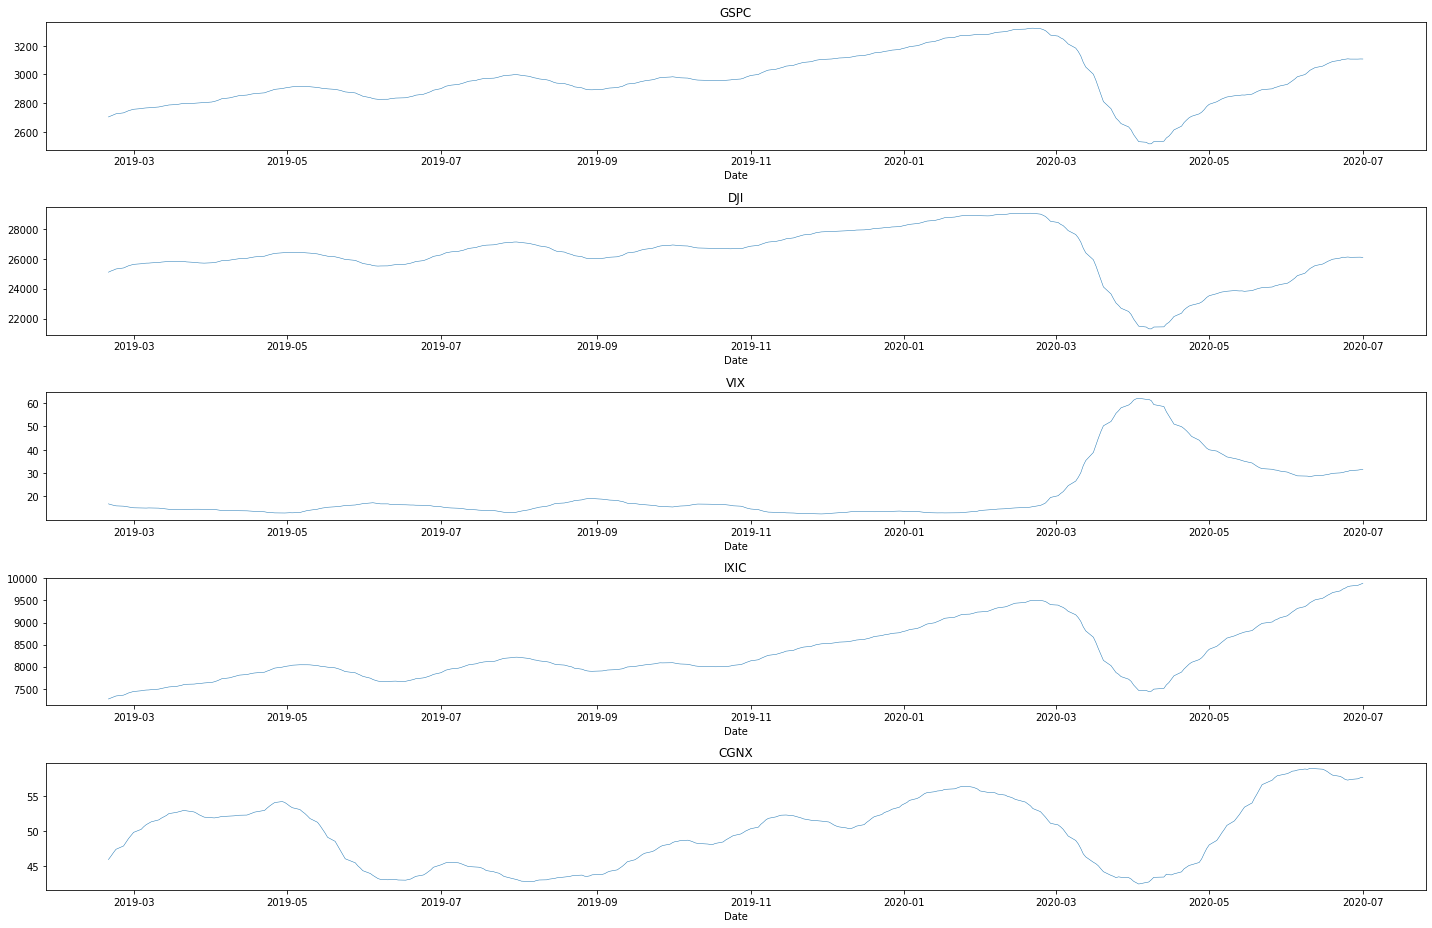

In [ ]:
gspc = market_index_df.GSPC_close_20day_mean	
dji = market_index_df.DJI_close_20day_mean
vix = market_index_df.VIX_close_20day_mean
ixic = market_index_df.IXIC_close_20day_mean
cgnx = market_index_df.CGNX_close_20day_mean

f1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(20, 13))
# f1.suptitle('Returns', fontsize=16)

gspc.plot(subplots=True, ax=ax1, legend=False, sharex=False, sharey=False,linewidth=0.5)
ax1.set_title('GSPC')

dji.plot(subplots=True, ax=ax2, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax2.set_title('DJI')

vix.plot(subplots=True, ax=ax3, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax3.set_title('VIX')

ixic.plot(subplots=True, ax=ax4, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax4.set_title('IXIC')

cgnx.plot(subplots=True, ax=ax5, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax5.set_title('CGNX')

f1.tight_layout()

# plt.subplots_adjust(left=0, bottom=1, right=1, top=1.5, wspace=0, hspace=0)

plt.show()

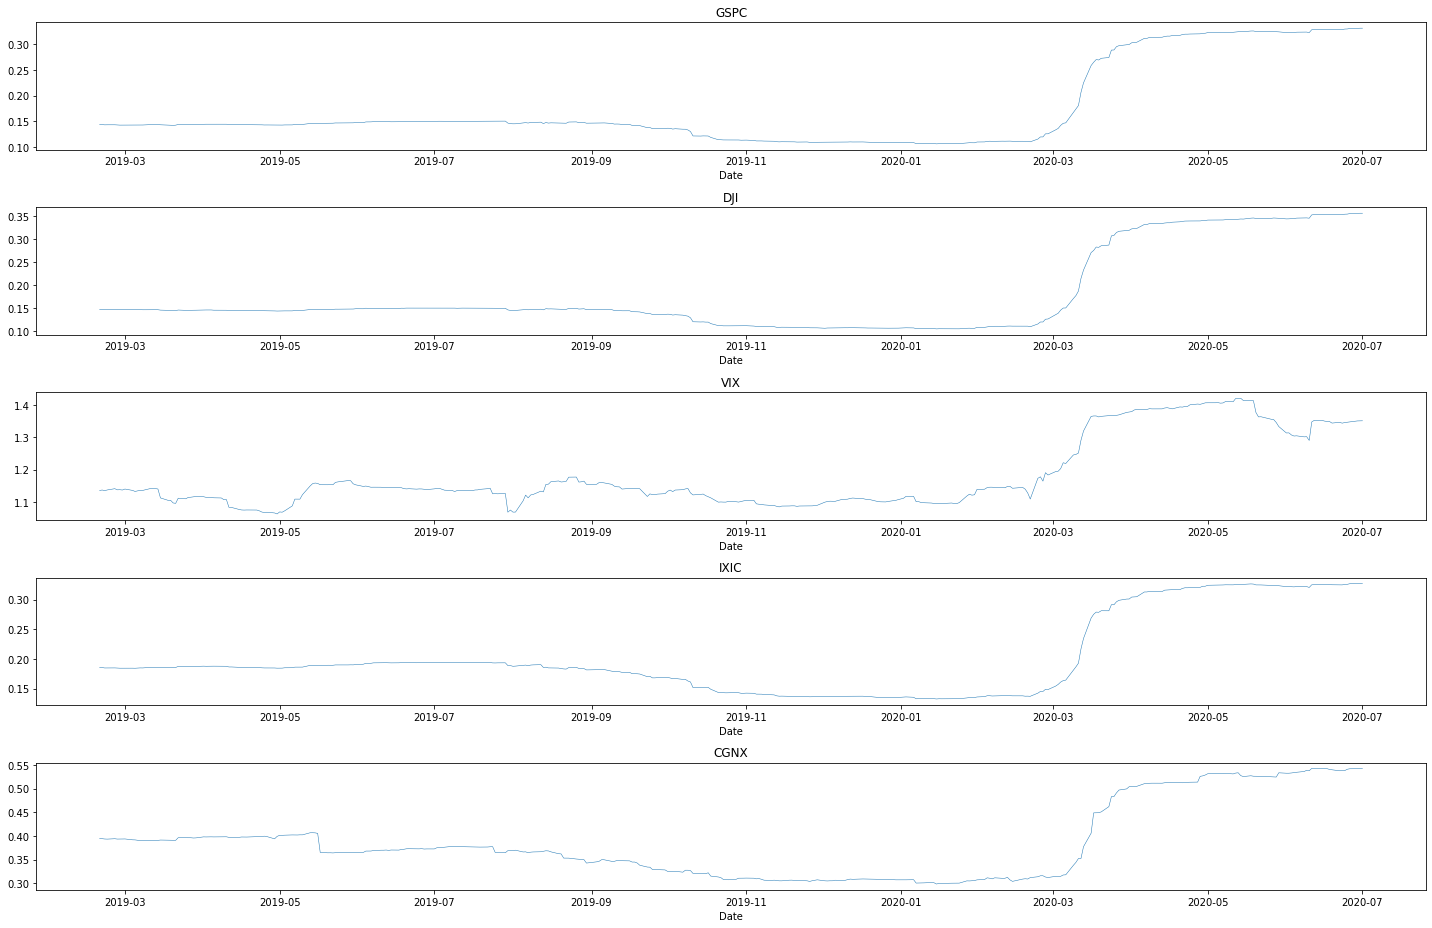

In [ ]:
gspc = market_index_df.GSPC_volatility
dji = market_index_df.DJI_volatility
vix = market_index_df.VIX_volatility
ixic = market_index_df.IXIC_volatility
cgnx = market_index_df.CGNX_volatility

f1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(20, 13))
# f1.suptitle('Returns', fontsize=16)

gspc.plot(subplots=True, ax=ax1, legend=False, sharex=False, sharey=False,linewidth=0.5)
ax1.set_title('GSPC')

dji.plot(subplots=True, ax=ax2, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax2.set_title('DJI')

vix.plot(subplots=True, ax=ax3, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax3.set_title('VIX')

ixic.plot(subplots=True, ax=ax4, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax4.set_title('IXIC')

cgnx.plot(subplots=True, ax=ax5, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax5.set_title('CGNX')

f1.tight_layout()

# plt.subplots_adjust(left=0, bottom=1, right=1, top=1.5, wspace=0, hspace=0)

plt.show()

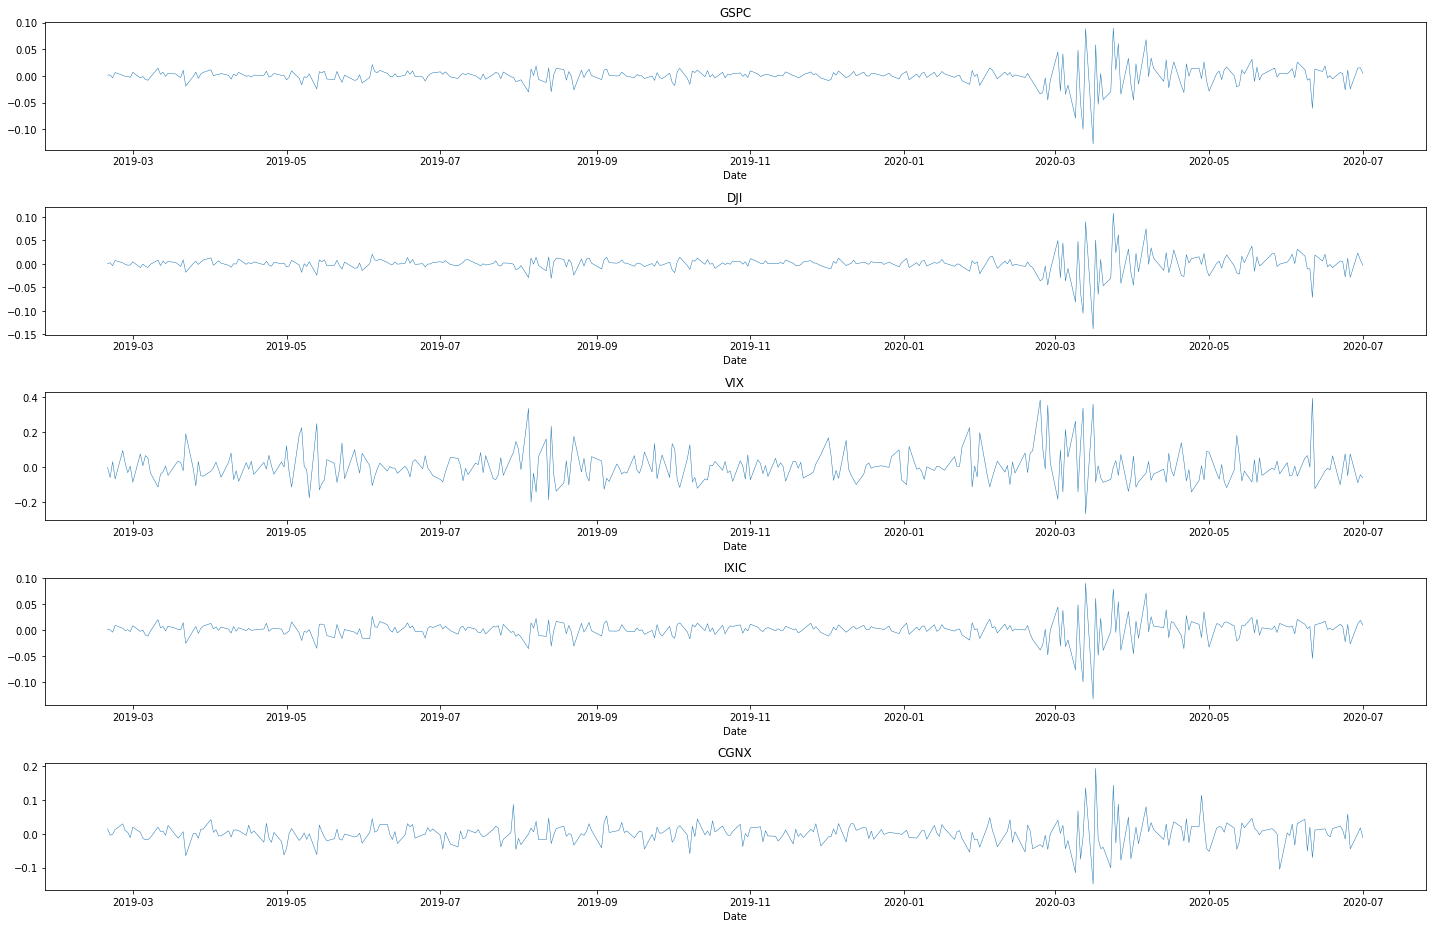

In [ ]:
gspc = market_index_df.GSPC_log_returns
dji = market_index_df.DJI_log_returns
vix = market_index_df.VIX_log_returns
ixic = market_index_df.IXIC_log_returns
cgnx = market_index_df.CGNX_log_returns

f1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(20, 13))
# f1.suptitle('Returns', fontsize=16)

gspc.plot(subplots=True, ax=ax1, legend=False, sharex=False, sharey=False,linewidth=0.5)
ax1.set_title('GSPC')

dji.plot(subplots=True, ax=ax2, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax2.set_title('DJI')

vix.plot(subplots=True, ax=ax3, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax3.set_title('VIX')

ixic.plot(subplots=True, ax=ax4, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax4.set_title('IXIC')

cgnx.plot(subplots=True, ax=ax5, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax5.set_title('CGNX')

f1.tight_layout()

# plt.subplots_adjust(left=0, bottom=1, right=1, top=1.5, wspace=0, hspace=0)

plt.show()

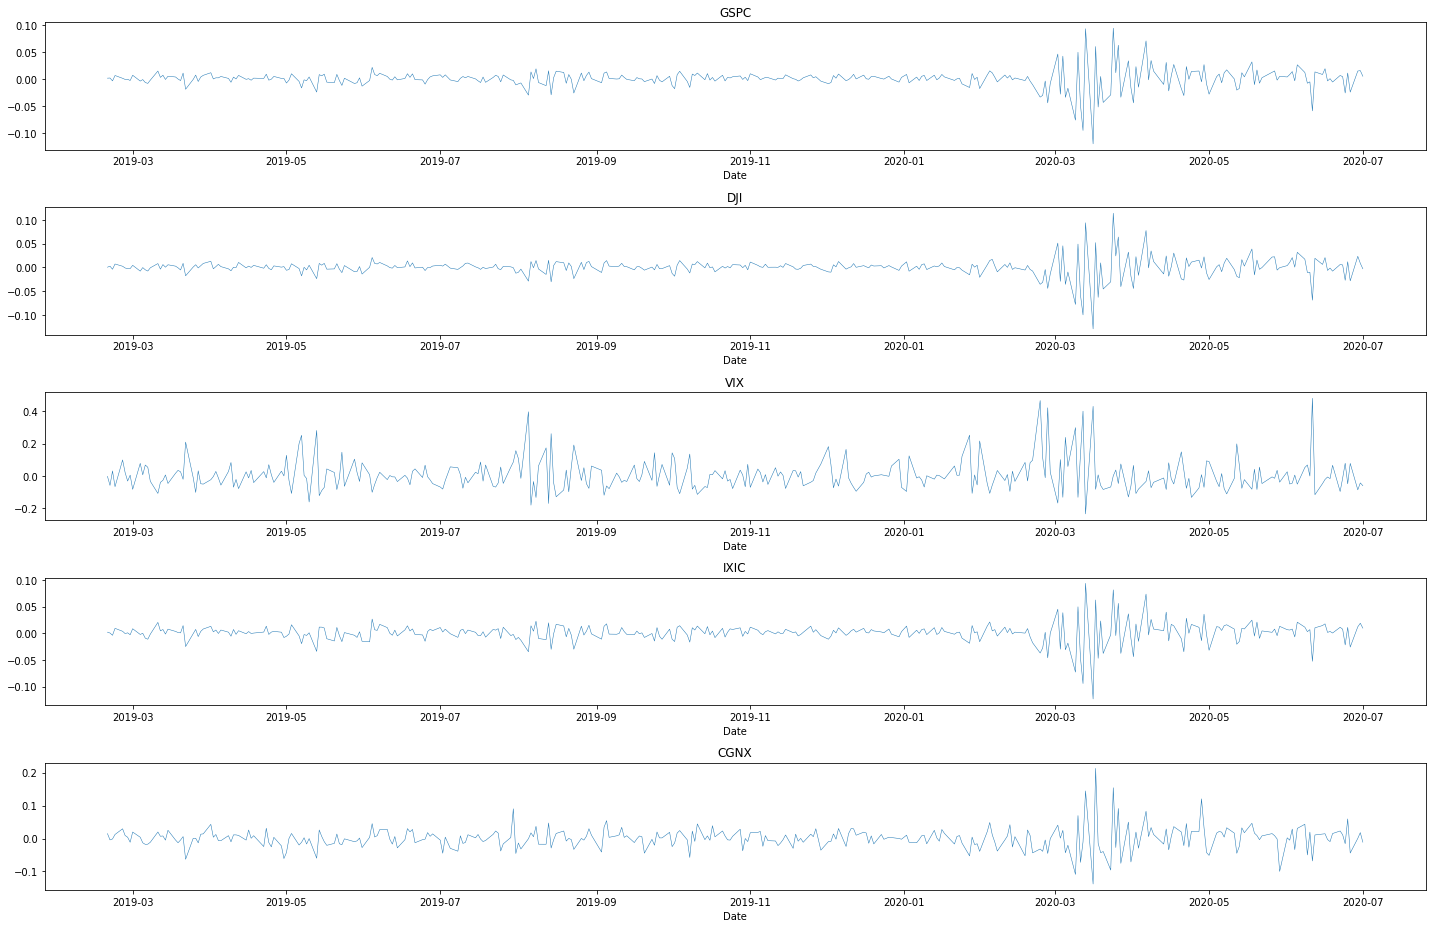

In [ ]:
# plot raw series from data

gspc = market_index_df.GSPC_returns
dji = market_index_df.DJI_returns
vix = market_index_df.VIX_returns
ixic = market_index_df.IXIC_returns
cgnx = market_index_df.CGNX_returns

f1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(20, 13))
# f1.suptitle('Returns', fontsize=16)

gspc.plot(subplots=True, ax=ax1, legend=False, sharex=False, sharey=False,linewidth=0.5)
ax1.set_title('GSPC')

dji.plot(subplots=True, ax=ax2, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax2.set_title('DJI')

vix.plot(subplots=True, ax=ax3, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax3.set_title('VIX')

ixic.plot(subplots=True, ax=ax4, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax4.set_title('IXIC')

cgnx.plot(subplots=True, ax=ax5, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax5.set_title('CGNX')

f1.tight_layout()

# plt.subplots_adjust(left=0, bottom=1, right=1, top=1.5, wspace=0, hspace=0)

plt.show()

In [ ]:
gspc = market_index_df.GSPC_returns
dji = market_index_df.DJI_returns
vix = market_index_df.VIX_returns
ixic = market_index_df.IXIC_returns
cgnx = market_index_df.CGNX_returns

f1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(20, 13))
# f1.suptitle('Returns', fontsize=16)

gspc.plot(subplots=True, ax=ax1, legend=False, sharex=False, sharey=False,linewidth=0.5)
ax1.set_title('GSPC')

dji.plot(subplots=True, ax=ax2, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax2.set_title('DJI')

vix.plot(subplots=True, ax=ax3, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax3.set_title('VIX')

ixic.plot(subplots=True, ax=ax4, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax4.set_title('IXIC')

cgnx.plot(subplots=True, ax=ax5, legend=False, sharex=False, sharey=False, linewidth=0.5)
ax5.set_title('CGNX')

f1.tight_layout()

# plt.subplots_adjust(left=0, bottom=1, right=1, top=1.5, wspace=0, hspace=0)

plt.show()

# Technical Indicators
* CGNEX and Market Indices